In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer
from qcc.qcnn import QCNN

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D
from qcc.experiment import Experiment
from qcc.cnn import CNN

from pathlib import Path
from qcc.file import save_dataframe_as_csv

from qcc.quantum.operation.ansatz import ConvolutionPoolingAnsatz as Ansatz
# from qcc.quantum.operation.ansatz import BaselineAnsatz as Ansatz

from qcc.quantum.operation.ansatz.basic import BasicFiltering

In [2]:
# Meta parameters
name = "name"
path = Path(f"results/{name}")
num_trials = 10
silent = False
is_quantum = True

# Ansatz parameters
dims = (28, 28)
num_layers = 4
options = {
    "U_filter": BasicFiltering
}

2023-06-25 02:39:03,353: (qcnn) Circuit ID: name


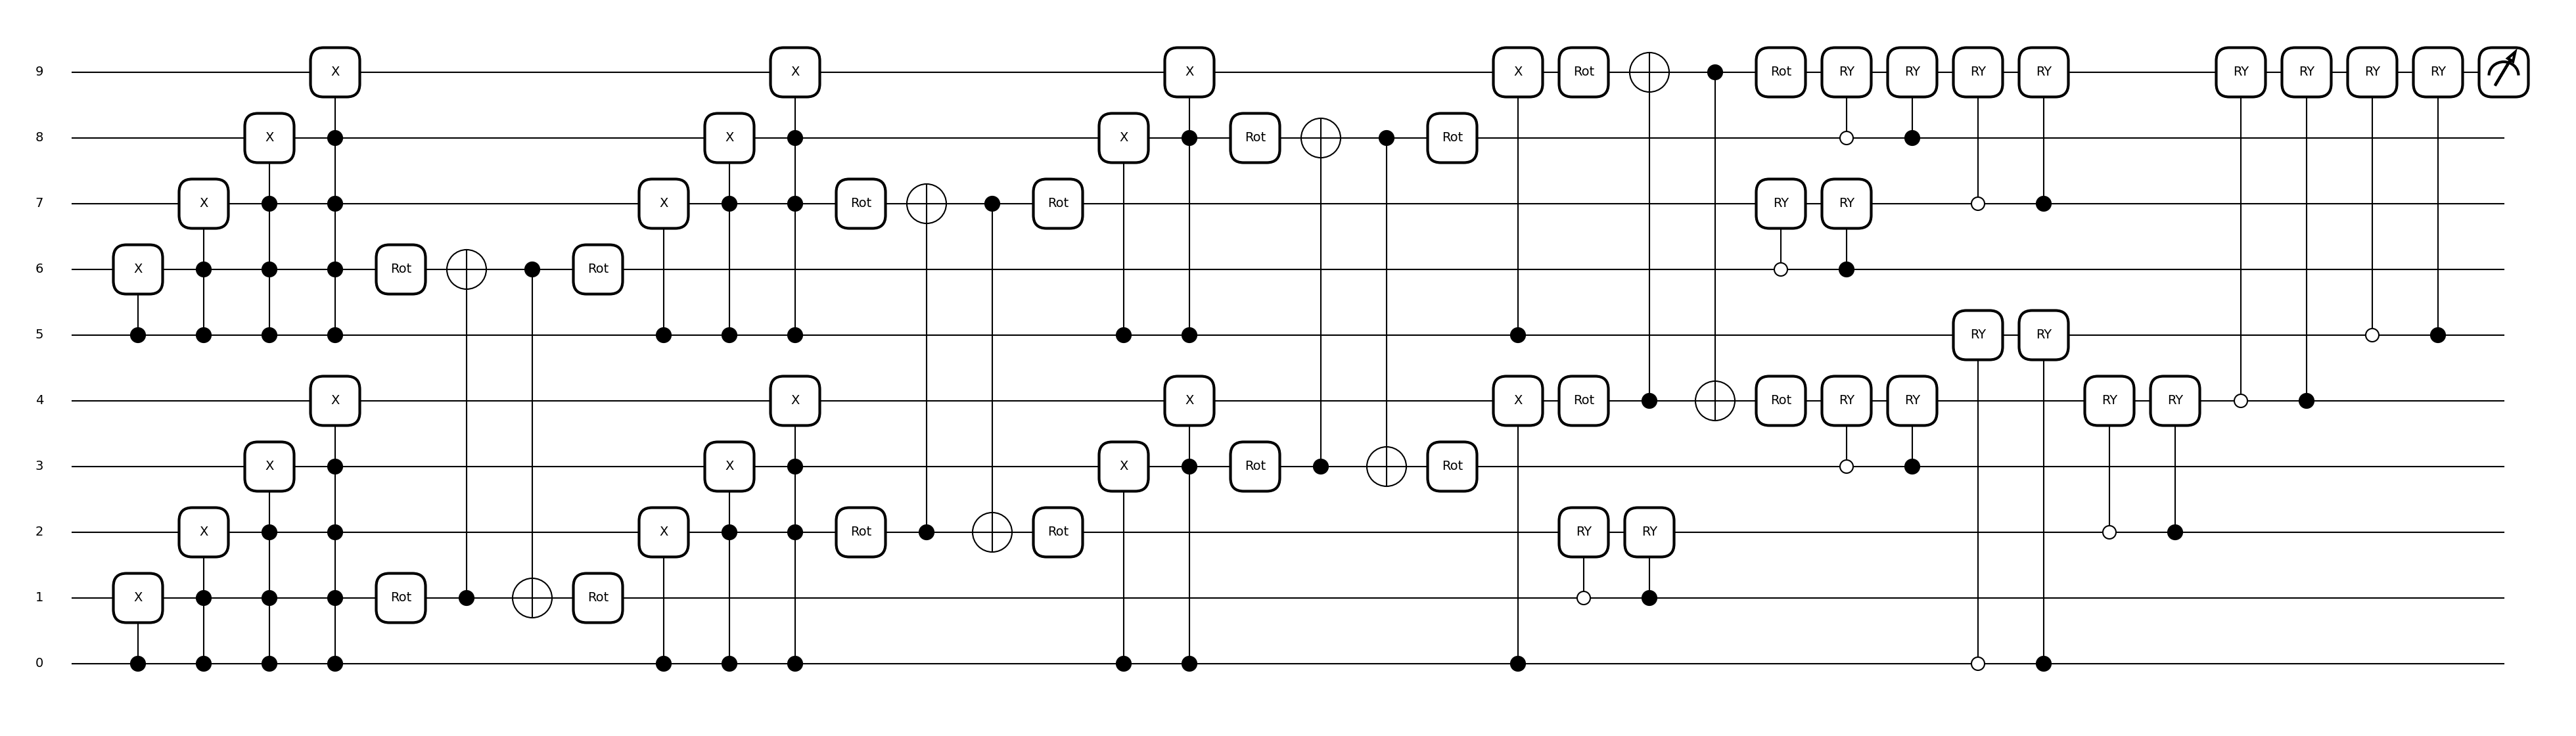

In [3]:
# Create model
cls = QCNN if is_quantum else CNN
data = BinaryData(FashionMNIST, ImageTransform(dims, flatten=is_quantum), batch_size=(4, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
epoch = 1
model = cls.with_logging(data, optimizer, loss, epoch=epoch)

# Log circuit ID
model.logger.info(f"Circuit ID: {name}")

# Save circuit drawing
if is_quantum:
    model.ansatz = Ansatz.from_dims(dims, num_layers=num_layers, **options)
    filename = path.with_stem(f"{name}_circuit").with_suffix(".png")
    model.ansatz.draw(filename=filename, decompose=True)

In [4]:
# Run experiment
experiment = Experiment(model, num_trials, results_schema=["accuracy"])

args = (Ansatz,) if is_quantum else ()
results = experiment(*args, dims, num_layers=num_layers, silent=silent, **options)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%
2023-06-25 02:39:11,126: (qcnn_trial_0) Number of Parameters: 66


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



KeyboardInterrupt: 

In [ ]:
# Save and print accuracy results
save_dataframe_as_csv(path.with_suffix(".csv"), results)
acc = results["accuracy"]
print(acc.median(), acc.mean(), acc.std())

In [ ]:
# Save aggregated loss history figure
(fig,) = experiment.draw(path.with_suffix(".png"))